# Multivariate SPX LSTM Prediction

Let's predict the BTC price based on close price and RSI using only one LSTM layer

In [33]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import math
from keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from stockstats import StockDataFrame as Sdf

In [2]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    # if IS_COLAB:
    #     print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)

In [54]:
np.random.seed(24)
tf.random.set_seed(24)

The goal is to get the best prediction for the last value (price).

In [3]:
def last_step_mse(y_true, y_pred):
    return keras.metrics.mean_squared_error(y_true[-1], y_pred[-1])

Split dataset to multivariate samples.

In [4]:
def split_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(sequence.shape[0]):
        end_x_seq = i + n_steps
        # break if there is no enough data to add new X and y seqs
        if end_x_seq >= sequence.shape[0]:
            break
        # take and collet data sequences
        seq_X, seq_y = sequence[i:end_x_seq], sequence[end_x_seq, 0] 
        X.append(seq_X)
        y.append(seq_y)
    return np.array(X), np.array(y)

Data initialisation and clearing the table.

In [5]:
def init_data(file_name):
    data = pd.read_csv('Data/'+file_name)
    data = data.set_index('Date')
    data.index = pd.to_datetime(data.index)
    return data

def clear_columns(pd):
    return pd.drop(["high", "low", "open", "volume",
                    "Adj Close"], axis=1)

Data verification function.

In [16]:
def check_data(df):
    print('====head=====')
    print(df.head())
    print('====describe=====')
    print(df.describe())
    print('====info=====')
    print(df.info())
    print('====shape=====')
    print(df.shape)
    print('====quantity of null=====')
    print(df.isnull().sum())
    print('====quantity of na=====')
    print(df.isna().sum())
    print('====all nan rows if any=====')
    print(df[df.isna().any(axis=1)])
    print('====inf values=====')
    print(np.isinf(df).any())
    print('====0s values=====')
    print((df == 0).sum(axis=1).any())
    # (df == 0).astype(int).sum(axis=1)

Load the BTC data.

In [13]:
spx_1d_data = init_data('SPX_71_21.csv')
spx_1d_data = clear_columns(spx_1d_data)

Check data.

In [17]:
check_data(spx_1d_data)

====head=====
                close
Date                 
1971-01-04  91.150002
1971-01-05  91.800003
1971-01-06  92.349998
1971-01-07  92.379997
1971-01-08  92.190002
====describe=====
              close
count  12842.000000
mean     941.332879
std      929.300562
min       62.279999
25%      158.764999
50%      655.595001
75%     1339.625031
max     4704.540039
====info=====
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12842 entries, 1971-01-04 to 2021-11-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   12842 non-null  float64
dtypes: float64(1)
memory usage: 200.7 KB
None
====shape=====
(12842, 1)
====quantity of null=====
close    0
dtype: int64
====quantity of na=====
close    0
dtype: int64
====all nan rows if any=====
Empty DataFrame
Columns: [close]
Index: []
====inf values=====
close    False
dtype: bool
====0s values=====
False


Let's use stockstats lib to calculate the RSI.

In [18]:
stock = Sdf.retype(spx_1d_data)

In [19]:
rsi = stock['rsi_14'] 

In [20]:
rsi

Date
1971-01-04           NaN
1971-01-05    100.000000
1971-01-06    100.000000
1971-01-07    100.000000
1971-01-08     84.330443
                 ...    
2021-11-17     64.256314
2021-11-18     65.867482
2021-11-19     44.444680
2021-11-20     53.658803
2021-11-21     42.587913
Name: rsi_14, Length: 12842, dtype: float64

Updated DataFrame.

In [21]:
spx_1d_data

,close,close_-1_s,close_-1_d,closepm,closenm,closepm_14_smma,closenm_14_smma,rs_14,rsi_14
Date,,,,,,,,,
1971-01-04,91.150002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1971-01-05,91.800003,91.150002,0.650002,0.650002,0.000000,0.650002,0.000000,inf,100.000000
1971-01-06,92.349998,91.800003,0.549995,0.549995,0.000000,0.598147,0.000000,inf,100.000000
1971-01-07,92.379997,92.349998,0.029999,0.029999,0.000000,0.394569,0.000000,inf,100.000000
1971-01-08,92.190002,92.379997,-0.189995,0.000000,0.189995,0.284706,0.052902,5.381801,84.330443
...,...,...,...,...,...,...,...,...,...
2021-11-17,4690.700195,4682.939941,7.760254,7.760254,0.000000,11.266860,6.267385,1.797697,64.256314
2021-11-18,4701.459961,4690.700195,10.759766,10.759766,0.000000,11.230639,5.819715,1.929757,65.867482
2021-11-19,4594.620117,4701.459961,-106.839844,0.000000,106.839844,10.428450,13.035439,0.800008,44.444680


Let's keep only close price and rsi_14.

In [23]:
spx_1d_data = spx_1d_data[['close', 'rsi_14']]

In [25]:
spx_1d_data[:10]

,close,rsi_14
Date,,
1971-01-04,91.150002,NaN
1971-01-05,91.800003,100.000000
1971-01-06,92.349998,100.000000
1971-01-07,92.379997,100.000000
1971-01-08,92.190002,84.330443
1971-01-11,91.980003,71.073980
1971-01-12,92.720001,81.882080
1971-01-13,92.559998,75.328146
1971-01-14,92.800003,78.152913


Drop four fisrt rows.

In [26]:
spx_1d_data = spx_1d_data[4:]

In [27]:
spx_1d_data[:10]

,close,rsi_14
Date,,
1971-01-08,92.190002,84.330443
1971-01-11,91.980003,71.073980
1971-01-12,92.720001,81.882080
1971-01-13,92.559998,75.328146
1971-01-14,92.800003,78.152913
1971-01-15,93.029999,80.461544
1971-01-18,93.410004,83.553831
1971-01-19,93.760002,85.785291
1971-01-20,93.779999,85.902977


There are two different scales so to perform the prediction the standardization of the data is needed.

In [65]:
scaler = StandardScaler()

In [66]:
spx_scaled = scaler.fit_transform(spx_1d_data.values)

In [67]:
spx_scaled

array([[-0.91404107,  2.52488367],
       [-0.91426704,  1.42790264],
       [-0.91347074,  2.32228003],
       ...,
       [ 3.93099016, -0.77568935],
       [ 3.99625507, -0.01321464],
       [ 3.90126836, -0.92933798]])

In [68]:
spx_scaled.shape == spx_1d_data.shape

True

Split data to train, val and test set.

In [34]:
test_size = 33 # let's leave 33 sessions for testing
seq_length = 32
dataset_size = spx_scaled.shape[0]
X_train, y_train = split_sequence(spx_scaled[0: math.ceil(0.7 * dataset_size)], seq_length)
X_val, y_val = split_sequence(spx_scaled[math.floor(0.7 * dataset_size):-test_size], seq_length)
X_test, y_test = split_sequence(spx_scaled[-test_size:], seq_length)

Verify the sets.

In [35]:
print(f'X_train shape is: {X_train.shape}')
print(f'y_train shape is: {y_train.shape}')
print(f'X_val shape is: {X_val.shape}')
print(f'y_val shape is: {y_val.shape}')
print(f'X_test shape is: {X_test.shape}')
print(f'y_test shape is: {y_test.shape}')

X_train shape is: (8955, 32, 2)
y_train shape is: (8955,)
X_val shape is: (3787, 32, 2)
y_val shape is: (3787,)
X_test shape is: (1, 32, 2)
y_test shape is: (1,)


Standard model parameters.

In [95]:
n_steps = X_train.shape[-2]
n_features = X_train.shape[-1]
epochs = 64

Simple RNN model. 

In [96]:
# RNN model 
# hyperparameters to be found by keras tuner
model = keras.Sequential()
model.add(LSTM(units=200, activation="tanh", 
               activity_regularizer=keras.regularizers.l2(1e-4),
              input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=[last_step_mse])

history = model.fit(X_train, y_train, 
                    epochs=epochs,
                    validation_data=(X_val, y_val)
                    )

Epoch 1/64
280/280 [==============================] - 3s 12ms/step - loss: 0.0060 - last_step_mse: 0.0060 - val_loss: 0.0619 - val_last_step_mse: 0.0675
Epoch 2/64
280/280 [==============================] - 3s 11ms/step - loss: 1.6647e-04 - last_step_mse: 1.2229e-04 - val_loss: 0.0537 - val_last_step_mse: 0.0581
Epoch 3/64
280/280 [==============================] - 3s 11ms/step - loss: 1.5506e-04 - last_step_mse: 6.7776e-05 - val_loss: 0.0417 - val_last_step_mse: 0.0449
Epoch 4/64
280/280 [==============================] - 3s 11ms/step - loss: 1.4640e-04 - last_step_mse: 1.1288e-04 - val_loss: 0.0325 - val_last_step_mse: 0.0348
Epoch 5/64
280/280 [==============================] - 3s 11ms/step - loss: 1.5145e-04 - last_step_mse: 8.8549e-05 - val_loss: 0.0310 - val_last_step_mse: 0.0329
Epoch 6/64
280/280 [==============================] - 3s 11ms/step - loss: 1.4028e-04 - last_step_mse: 1.0305e-04 - val_loss: 0.0238 - val_last_step_mse: 0.0251
Epoch 7/64
280/280 [======================

280/280 [==============================] - 3s 10ms/step - loss: 7.7897e-05 - last_step_mse: 6.7608e-05 - val_loss: 0.0022 - val_last_step_mse: 0.0021
Epoch 52/64
280/280 [==============================] - 3s 10ms/step - loss: 7.7763e-05 - last_step_mse: 6.0950e-05 - val_loss: 0.0015 - val_last_step_mse: 0.0015
Epoch 53/64
280/280 [==============================] - 3s 11ms/step - loss: 8.6414e-05 - last_step_mse: 7.6818e-05 - val_loss: 0.0026 - val_last_step_mse: 0.0026
Epoch 54/64
280/280 [==============================] - 3s 11ms/step - loss: 7.9567e-05 - last_step_mse: 5.8639e-05 - val_loss: 0.0014 - val_last_step_mse: 0.0013
Epoch 55/64
280/280 [==============================] - 3s 10ms/step - loss: 7.7371e-05 - last_step_mse: 6.2413e-05 - val_loss: 0.0014 - val_last_step_mse: 0.0013
Epoch 56/64
280/280 [==============================] - 3s 11ms/step - loss: 7.8958e-05 - last_step_mse: 5.4277e-05 - val_loss: 0.0029 - val_last_step_mse: 0.0029
Epoch 57/64
280/280 [===================

Let's check the plot results.

In [97]:
def plot_loss_results(history):
    plt.figure(figsize=(15, 8))
    sns.lineplot(data=history.history['loss'], label='train mse')
    sns.lineplot(data=history.history['val_loss'], label='valid mse')
    sns.lineplot(data=history.history['last_step_mse'], label='last step mse')
    sns.lineplot(data=history.history['val_last_step_mse'], label='val last step mse')
    plt.title('Loss results for SXP prediction model', size='x-large')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0, 0.005)

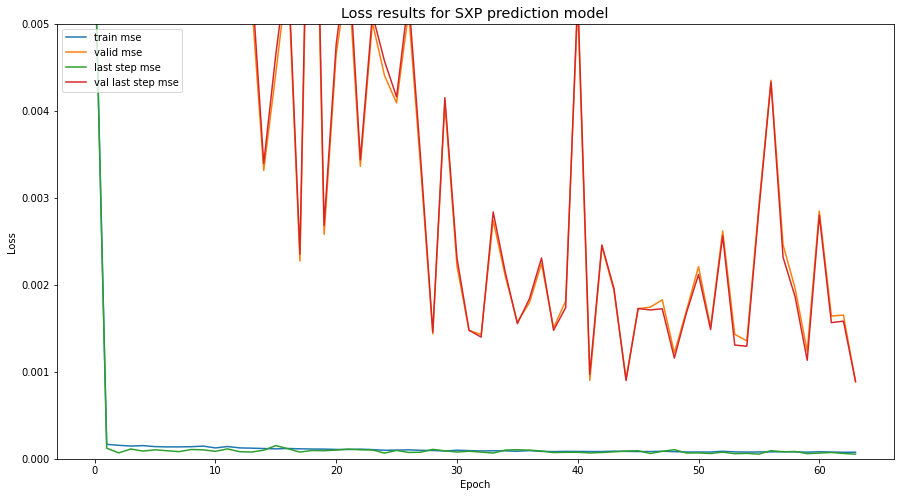

In [122]:
plot_loss_results(history)

Test the model.

In [115]:
prediction = model.predict(X_test)

The model predict only one value, but in the scaler there are two so let's imitate that there is also the second prediction. That does not matter what there be there because only the first one is important here, second to be ignored.

In [116]:
prediction = np.append(prediction, prediction)

In [117]:
prediction

array([3.9637756, 3.9637756], dtype=float32)

In [118]:
price = scaler.inverse_transform(prediction)[0]

In [119]:
price

4625.0874

In [120]:
f'The predicted price is {price:2.2f} while the true price is {scaler.inverse_transform(np.append(y_test, y_test))[0]}'

'The predicted price is 4625.09 while the true price is 4567.0'

In [121]:
f'The previous price: {spx_1d_data.close[-2]:2.2f}'

'The previous price: 4655.27'

The model has to be tested on bigger test set to consider it as a promising one, obviously.